In [1]:
# Imporing Required Libraries

import pandas as pd
import numpy as np

In [2]:
# Libraries for Data Visualisation
import os
import cv2
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.metrics import fbeta_score
from tqdm import tqdm
import tensorflow as tf
from keras import optimizers
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
import tensorflow_addons as tfa

In [3]:
path = "../input/planets-dataset/"
os.listdir(path)

['planet', 'test-jpg-additional']

In [5]:
train_label = pd.read_csv("/kaggle/input/planets-dataset/planet/planet/train_classes.csv")
train_label.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [6]:
labels = set()
def splitting_tags(tags):
    '''
    Takes in tags column, splits the tags and store as a set
    '''
    [labels.add(tag) for tag in tags.split()]
    
# Create a copy of train_label
train = train_label.copy()
train['tags'].apply(splitting_tags)
labels = list(labels)
print(labels)

['habitation', 'blooming', 'bare_ground', 'clear', 'cloudy', 'agriculture', 'primary', 'selective_logging', 'slash_burn', 'partly_cloudy', 'blow_down', 'haze', 'cultivation', 'water', 'road', 'artisinal_mine', 'conventional_mine']


In [10]:
len(labels)

17

In [7]:
##One hot encoding is performed on the labels in train classes 

for tag in labels:
    train[tag] = train['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
## adding .jpg extension to the column image_name so as to have same name format as the image files
train['image_name'] = train['image_name'].apply(lambda x: '{}.jpg'.format(x))
train.head()

,image_name,tags,habitation,blooming,bare_ground,clear,cloudy,agriculture,primary,selective_logging,slash_burn,partly_cloudy,blow_down,haze,cultivation,water,road,artisinal_mine,conventional_mine
0,train_0.jpg,haze primary,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0
2,train_2.jpg,clear primary,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,train_3.jpg,clear primary,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,1,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0


In [8]:
#importing libraries for training
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
# Defining the columns,i.e the labels that were newly added to the train_classes via hot encoding.
columns = list(train.columns[2:])

In [16]:
columns

['blow_down',
 'clear',
 'blooming',
 'selective_logging',
 'slash_burn',
 'haze',
 'cultivation',
 'partly_cloudy',
 'conventional_mine',
 'bare_ground',
 'agriculture',
 'water',
 'habitation',
 'primary',
 'road',
 'cloudy',
 'artisinal_mine']

In [10]:
def fbeta(y_true, y_pred, beta = 2, epsilon = 1e-4):
    '''
    Set y_true and y_pred

    Args:
        y_true: correct target values
        Y_pred: predicted values returned by the classifer
        beta = 2
        epsilon= 1e-4
        
    Returns:
        fbeta score
    '''
    
    beta_squared = beta**2
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp
    
    precision = tp/(tp+fp+epsilon)
    recall = tp/(tp+fn+epsilon)
    
    fb = (1+beta_squared)*precision*recall / (beta_squared*precision+recall+epsilon)
    return fb

In [11]:
def multi_label_acc(y_true, y_pred, epsilon = 1e-4):
    '''
    Retuns accuracy value for multi_label classification
    
    Set y_true and y_pred

    Args:
        y_true: correct target values
        Y_pred: predicted values returned by the classifer
        epsilon= 1e-4
        
    Returns:
        Accuracy score
    '''
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp
    
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)
        
    tn = tf.reduce_sum(tf.cast(tf.logical_not(y_true), tf.float32)
                       * tf.cast(tf.logical_not(y_pred), tf.float32), axis = 1)
    
    return (tp+tn)/(tp+tn+fp+fn+epsilon)

In [12]:
def build_simple_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (240, 240, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation = 'relu'),
        tf.keras.layers.Dense(17, activation = 'sigmoid')
    ])

    # Compile the model
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [multi_label_acc, fbeta])
    return model

def build_enet_model():
    model = tf.keras.applications.EfficientNetB1(
        include_top=True,
        classes=17,
        weights=None,
        classifier_activation="sigmoid",
    )
    # model.summary()
    opt = Adam(lr=1e-5)

    # We need binary here, since categorical_crossentropy l1 norms the output before calculating loss.
    model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=[multi_label_acc, fbeta])
    return model

In [13]:
#modelcheckpoint is set to monitor the model using validation fbeta score and save the best only
save_best_check_point = ModelCheckpoint(filepath='best_model.hdf5', 
                                        monitor='val_fbeta',
                                        mode='max',
                                        save_best_only = True,
                                        save_weights_only = True)

In [14]:
train_image_gen = ImageDataGenerator(rescale = 1/255, validation_split = 0.2, horizontal_flip=True, vertical_flip=True, brightness_range=(0.8,1.2))
# train_image_gen = ImageDataGenerator(rescale = 1/255, validation_split = 0.2)

#generating train data generator which is 80% of the train dataset
#note that a generator contains both features and target of the data
train_generator = train_image_gen.flow_from_dataframe(dataframe=train,
                                                directory ="/kaggle/input/planets-dataset/planet/planet/train-jpg",  
                                                x_col="image_name", y_col=columns, subset="training", 
                                                batch_size=16,seed=8888, shuffle=True, 
                                                class_mode="raw", target_size=(240,240))

#generating validation data which is expected to be 20% of the train dataset since validation split is 0.2
val_generator = train_image_gen.flow_from_dataframe(dataframe=train,
                                                directory ="/kaggle/input/planets-dataset/planet/planet/train-jpg",  
                                                x_col="image_name", y_col=columns, subset="validation", 
                                                batch_size=16,seed=8888, shuffle=True, 
                                                class_mode="raw", target_size=(240,240))

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [16]:
import numpy as np
#setting up step size for training and validation image data
step_train_size = int(np.ceil(train_generator.samples / train_generator.batch_size))
step_val_size = int(np.ceil(val_generator.samples / val_generator.batch_size))

In [18]:
#initialize the model
model = build_enet_model()

In [19]:
model.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 240, 240, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 240, 240, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                     

In [ ]:
#fitting our model using the parameters already defined  
history=model.fit(x = train_generator,
           steps_per_epoch = step_train_size,
           validation_data = val_generator,
           validation_steps = step_val_size,epochs = 30,
           callbacks=[save_best_check_point])

Epoch 1/30


2023-06-26 19:28:11.093642: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inefficientnetb1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2024/2024 [==============================] - 529s 226ms/step - loss: 0.2019 - multi_label_acc: 0.9215 - fbeta: 0.7258 - val_loss: 0.1630 - val_multi_label_acc: 0.9370 - val_fbeta: 0.7881
Epoch 2/30
2024/2024 [==============================] - 449s 222ms/step - loss: 0.1511 - multi_label_acc: 0.9396 - fbeta: 0.8000 - val_loss: 0.1439 - val_multi_label_acc: 0.9471 - val_fbeta: 0.8390
Epoch 3/30
2024/2024 [==============================] - 448s 221ms/step - loss: 0.1363 - multi_label_acc: 0.9459 - fbeta: 0.8274 - val_loss: 0.1399 - val_multi_label_acc: 0.9443 - val_fbeta: 0.8231
Epoch 4/30
2024/2024 [==============================] - 447s 221ms/step - loss: 0.1265 - multi_label_acc: 0.9499 - fbeta: 0.8434 - val_loss: 0.1235 - val_multi_label_acc: 0.9515 - val_fbeta: 0.8432
Epoch 5/30
2024/2024 [==============================] - 447s 221ms/step - loss: 0.1195 - multi_label_acc: 0.9532 - fbeta: 0.8559 - val_loss: 0.1460 - val_multi_label_acc: 0.9453 - val_fbeta: 0.8340
Epoch 6/30
2024/2024 

In [37]:
#initializing a second model to make predictions
model2 = build_enet_model()

In [38]:
#loading in the weights of the trained model
model2.load_weights('best_model.hdf5')

In [39]:
##adding .jpg extension to image name in the sample submission file
sample_submission = pd.read_csv('/kaggle/input/planets-dataset/planet/planet/sample_submission.csv')
sample_submission1 = sample_submission.copy()
sample_submission1['image_name'] = sample_submission1['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample_submission1.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [40]:
# Divide the sample submission file into two splits,
# first test_df which contains the first 40669 images 
test_df = sample_submission1.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)
test_df.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [41]:
#initialize imagedatagenerator for the test images and also rescaling
test_image_gen = ImageDataGenerator(rescale = 1/255)

#creating a generator for the images found in the first test image files
test_generator = test_image_gen.flow_from_dataframe(dataframe=test_df, 
                                                directory="/kaggle/input/planets-dataset/planet/planet/test-jpg", 
                                                x_col="image_name", 
                                                y_col=None, 
                                                batch_size=16, 
                                                shuffle=False, 
                                                class_mode=None, 
                                                target_size=(240,240))

step_test_size = int(np.ceil(test_generator.samples/test_generator.batch_size))



Found 40669 validated image filenames.


In [42]:
#first, we reset the test generator to avoid shuffling of index as we want it to be orderly
test_generator.reset()
pred = model2.predict(test_generator, steps = step_test_size, verbose = 1)

2542/2542 [==============================] - 290s 113ms/step


In [43]:
#this is to get the filenames in the generator using the attribute .filenames
file_names = test_generator.filenames

#convert the predicted values to a dataframe and join two labels together if the probability of occurrance 
#of the label is greater than 0.5 
pred_tags = pd.DataFrame(pred)
pred_tags = pred_tags.apply(lambda x: ' '.join(np.array(labels)[x>0.5]), axis = 1)

#then the result should look like this 
result1 = pd.DataFrame({'image_name': file_names, 'tags': pred_tags})
result1.head()

,image_name,tags
0,test_0.jpg,clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,partly_cloudy primary
3,test_3.jpg,clear primary
4,test_4.jpg,partly_cloudy primary


In [44]:
#additional test dataset
add_test_df = sample_submission1.iloc[40669:]['image_name'].reset_index().drop('index', axis =1)
add_test_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [45]:
#creating a generator for the additional test image files
add_test_generator = test_image_gen.flow_from_dataframe(dataframe = add_test_df, 
                                                    directory ="/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional", 
                                                    x_col="image_name", 
                                                    y_col=None, 
                                                    batch_size=16, 
                                                    shuffle=False, 
                                                    class_mode=None, 
                                                    target_size=(240,240))


step_test_size2 = int(np.ceil(add_test_generator.samples/add_test_generator.batch_size))

Found 20522 validated image filenames.


In [46]:
#we reset the generator to avoid shuffling, then make prediction on the generator
add_test_generator.reset()
add_pred = model2.predict(add_test_generator, steps = step_test_size2, verbose = 1)

1283/1283 [==============================] - 147s 115ms/step


In [47]:
#this is to get the filenames in the generator using the attribute .filenames
file_names = add_test_generator.filenames

#convert the predicted values to a dataframe and join two labels together if the probability of occurrance 
#of the label is greater than 0.5
add_pred_tags = pd.DataFrame(add_pred)
add_pred_tags = add_pred_tags.apply(lambda x: ''.join(np.array(labels)[x>0.5]), axis = 1)

#then the result should look like this
result2 = pd.DataFrame({'image_name': file_names, 'tags': add_pred_tags})
result2.head()

,image_name,tags
0,file_0.jpg,clearprimary
1,file_1.jpg,partly_cloudyagriculturehabitationprimaryroad
2,file_10.jpg,hazewaterprimaryroad
3,file_100.jpg,clearwaterprimary
4,file_1000.jpg,clearprimary


In [48]:
#for the final result of the predicted tags for the test images,
# we need to concat the first and second results in 
#that order to avoid shuffling the index
last_result = pd.concat([result1, result2])

last_result = last_result.reset_index().drop('index', axis =1)

print(last_result.shape)
#print the final result
last_result.head()

(61191, 2)


,image_name,tags
0,test_0.jpg,clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,partly_cloudy primary
3,test_3.jpg,clear primary
4,test_4.jpg,partly_cloudy primary


In [49]:
#we need to remove the .jpg extension from the image_name of the
# last_result because from the sample submission the 
#extension was not there, we added it for easy manipulation of the data.
last_result['image_name'] = last_result['image_name'].apply(lambda x: x[:-4])
last_result.head()

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,clear primary
4,test_4,partly_cloudy primary


In [50]:
# Finally, we save the result to a csv file using the .to_csv() 
# method and setting the index to false.
last_result.to_csv('submission1.csv', index = False)

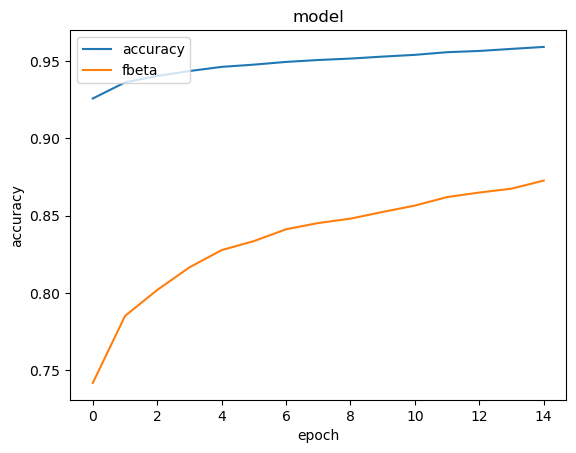

In [38]:
from matplotlib import pyplot as plt
plt.plot(history.history['multi_label_acc'])
plt.plot(history.history['fbeta'])
plt.title('model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'fbeta'], loc='upper left')
plt.show()

In [60]:
import shutil
shutil.make_archive("model.zip", 'zip', "model")

'/kaggle/working/model.zip.zip'